# Example 3 - Pendulum Autoencoder

# Initial Observations:
### To generate the images, run `data.py` which is located in the `data_pendulo` folder.
### The functions used here are in the `function.py` file.

# Pendulum Autoencoder

In this section, we will analyze a CNN Autoencoder network for the dynamics of a pendulum. Assuming that the reader has already generated the images with `data.py`, we will import the functions from the `function.py` file.


In [1]:
from function import *


Now, we will split our dataset into two parts, one for training and the other for validation. Additionally, in the `function.py` file, we take the `SimpleAutoencoder` class, where we declare our network in PyTorch in the same way we did in the previous examples, but now using convolutional layers. We recommend you look at how the declaration is done and notice that the Encoder and Decoder parts are mirrored between themselves.  
- In the cell below, we define `device = "cuda"`, but if you don't have CUDA installed for GPU processing, replace `"cuda"` with `"cpu"`.  
- For latent spaces with a different dimension, adjust the `neck` variable.


Epoch [1/2001], Loss: 0.0212
Epoch [201/2001], Loss: 0.0189
Epoch [401/2001], Loss: 0.0058
Epoch [601/2001], Loss: 0.0026
Epoch [801/2001], Loss: 0.0012
Epoch [1001/2001], Loss: 0.0008
Epoch [1201/2001], Loss: 0.0008
Epoch [1401/2001], Loss: 0.0007
Epoch [1601/2001], Loss: 0.0006
Epoch [1801/2001], Loss: 0.0006
Epoch [2001/2001], Loss: 0.0005
Treinamento concluído


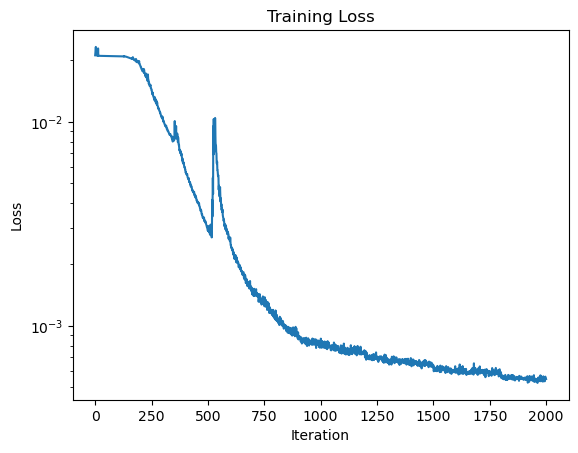

In [2]:
# Caminho para o diretório das imagens
root_dir = 'data_pendulo'  # Ajuste para o diretório onde suas imagens estão salvas

# dimensão do espaço latente
neck = 2
# DataLoader

train_dataset = CustomImageDataset(root_dir=root_dir)
test_dataset  = CustomImageDataset(root_dir=root_dir, split='test')
model         = SimpleAutoencoder(neck)  # Ajuste o parâmetro 'neck' conforme necessário
trainer       = Trainer(model, train_dataset,test_dataset, batch_size=30,step_size=300,device="cuda")
trainer.train(epochs=2001)


## Evaluation of Results

Let's now analyze the training of our model. We will recover its initial state `model_zero()`, mid-training state `model_intermed()`, and the final model `model`.


In [3]:
#Função para plotar as imagens reconstruidas:

def plot_image_comparison(input,output):    
    # Plotando as imagens
    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    ax[0].imshow(input_image, cmap='gray')
    ax[0].set_title('Imagem Original')
    ax[0].axis('off')
    ax[1].imshow(output, cmap='gray')
    ax[1].set_title('Imagem Reconstruída')
    ax[1].axis('off')
    plt.savefig("Imagem-Reconstruída",dpi=1000)
    plt.show()

## Recovering the Models Saved During Training

- If you want to skip the training part, you can simply load the models directly into memory as we did in the cell below.


In [4]:
# declarando modelos
model_zero = SimpleAutoencoder(neck) 
model_zero.load_state_dict(tc.load(f'saved_models/model_neck{neck}_parameters_epoch0.pth'))

# recuprando parametros salvos
model_intermed = SimpleAutoencoder(neck) 
model_intermed.load_state_dict(tc.load(f'saved_models/model_neck{neck}_parameters_epoch1000.pth'))

# colocando os modelos em modoe avaliação
model_zero.eval()
model_intermed.eval()

SimpleAutoencoder(
  (conv1): Conv2d(1, 5, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(5, 10, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encode3): Linear(in_features=16000, out_features=1600, bias=True)
  (encode2): Linear(in_features=1600, out_features=40, bias=True)
  (encode1): Linear(in_features=40, out_features=2, bias=True)
  (decoder1): Linear(in_features=2, out_features=40, bias=True)
  (decoder2): Linear(in_features=40, out_features=1600, bias=True)
  (decoder3): Linear(in_features=1600, out_features=16000, bias=True)
  (t_conv1): ConvTranspose2d(10, 5, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (t_conv2): ConvTranspose2d(5, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (act): SIN()
)

### Images Before Training


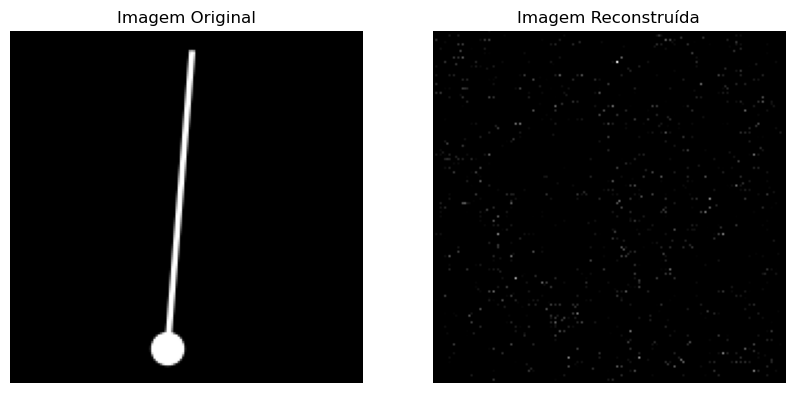

In [5]:
# Supondo que você quer testar com a primeira imagem do dataset de teste
dataiter = iter(trainer.test_dataloader)
images = next(dataiter)

# Executar a imagem pela rede
output, output2 = model_zero(images[0].unsqueeze(0))

# Converte a saída do modelo e a entrada para exibição
output = output.cpu().detach().numpy().squeeze()
input_image = images[0].cpu().detach().numpy().squeeze()

plot_image_comparison(input_image,output)

### Image Mid-Training


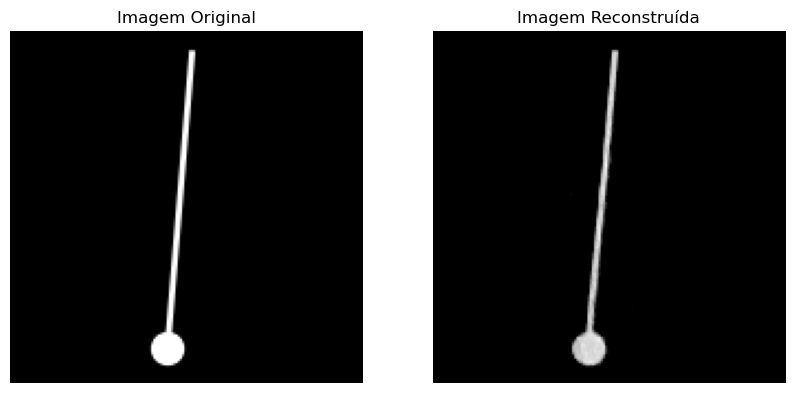

In [6]:
# Executar a imagem pela rede
output, output2 = model_intermed(images[0].unsqueeze(0))

# Converte a saída do modelo e a entrada para exibição
output = output.cpu().detach().numpy().squeeze()
input_image = images[0].cpu().detach().numpy().squeeze()

plot_image_comparison(input_image,output)

### Final Image After Training


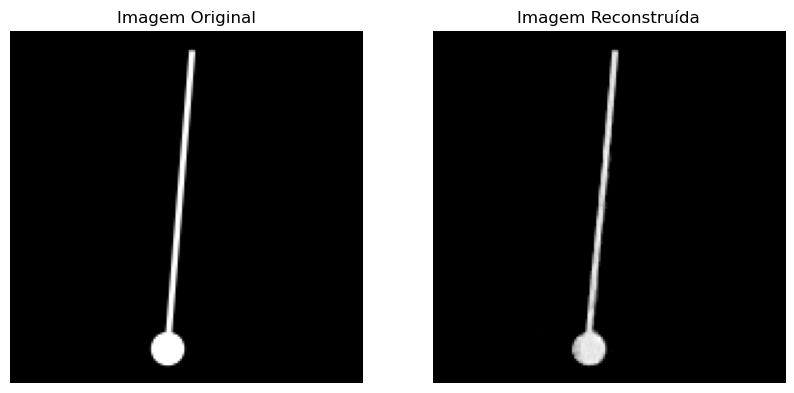

In [7]:
# Coloca o modelo em modo de avaliação
trainer.model.eval()

# Executar a imagem pela rede
output, output2 = trainer.model(images[0].unsqueeze(0).to(trainer.dev))

# Converte a saída do modelo e a entrada para exibição
output = output.cpu().detach().numpy().squeeze()
input_image = images[0].cpu().detach().numpy().squeeze()

plot_image_comparison(input_image, output)

## Adding Noise to the Images Without Altering the Network

We will add noise to the images and check if our network is still able to recognize them, even though it wasn't trained for this purpose. That is, our network was trained only with noise-free images.


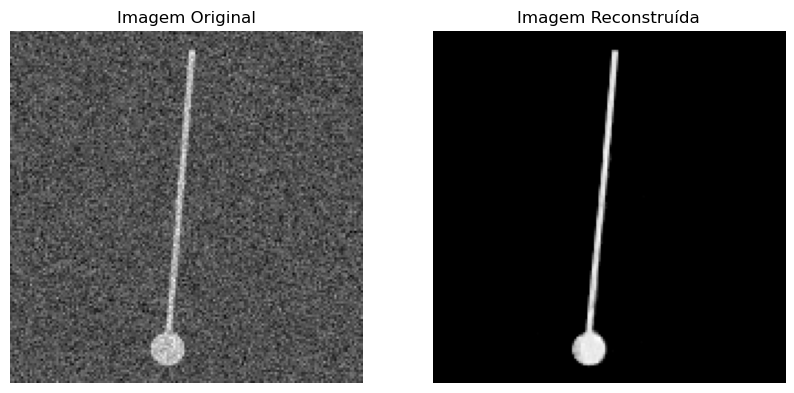

In [8]:
#Adicionando ruido a imagem
noise = tc.randn_like(images) * 0.2  # 20% de ruído

# Add the noise to the image
noisy_image = images[0] + noise

output, output2 = trainer.model(noisy_image[0].unsqueeze(0).to(trainer.dev))

# Converte a saída do modelo e a entrada para exibição
output = output.cpu().detach().numpy().squeeze()
input_image = noisy_image[0].cpu().detach().numpy().squeeze()

plot_image_comparison(input_image, output)

However, for higher noise levels, our network is unable to distinguish the object.


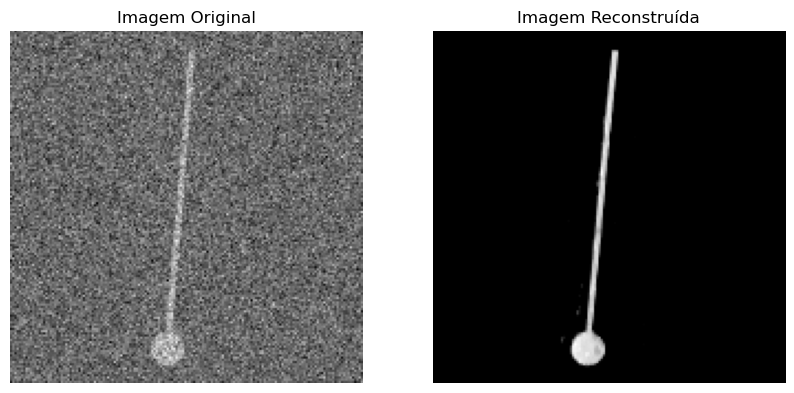

In [9]:
#Adicionando ruido a imagem
noise = tc.randn_like(images) * 0.4  # 40% de ruído

# Add the noise to the image
noisy_image = images[0] + noise

output, output2 = trainer.model(noisy_image[0].unsqueeze(0).to(trainer.dev))

# Converte a saída do modelo e a entrada para exibição
output = output.cpu().detach().numpy().squeeze()
input_image = noisy_image[0].cpu().detach().numpy().squeeze()

plot_image_comparison(input_image, output)

## Latent Space Study

Let's examine below how the latent space $z(t) = \varphi(\mathbf{x})$ behaves, in this case with a `neck=2` dimension.


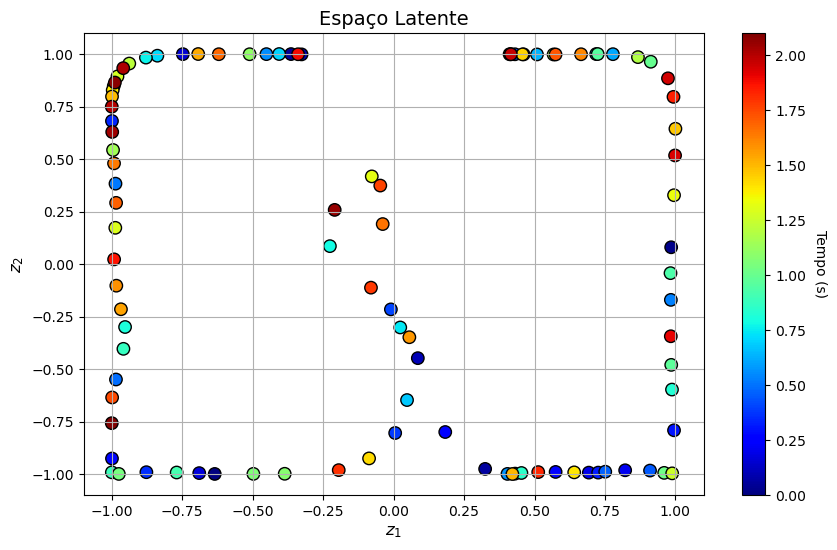

In [ ]:
time = np.linspace(0,2.1,100)
trainer.model.eval()  # Coloca o modelo em modo de avaliação
plt.figure(figsize=(10, 6))
for i, data in enumerate(trainer.test_dataloader, 0):
    data = data.to("cuda")  # Move data to GPU
    output,output2 = trainer.model(data)
    latente = output2.cpu().detach().numpy()

scatter = plt.scatter(latente[:, 0], latente[:, 1], c=time, cmap='jet', s=80, alpha=1.0, edgecolors='k')

# Adicionar colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Time (s)', rotation=270, labelpad=15)

# Definir título e labels
plt.title("Latent Space", fontsize=14)
plt.xlabel(r"$z_1$", fontsize=12)
plt.ylabel(r"$z_2$", fontsize=12)

# Adicionar grid
plt.grid(True)

# Mostrar o plot
plt.show()


Notice that the autoencoder found a non-linear representation of the dynamics in a 1-dimensional curve. However, the temporal order is scrambled. This is not an affine transformation of our original space $ \theta(t) \in \{-\pi, \pi\}$. Notice, however, that we can still find a way to make this work. Let's increase the space's dimension to one that contains time on a third axis.


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Importar o módulo 3D

# Suponha que `time` já está definido e `trainer` já foi treinado

time = np.linspace(0, 2.1, 100)
trainer.model.eval()  # Coloca o modelo em modo de avaliação

for i, data in enumerate(trainer.test_dataloader, 0):
    data = data.to("cuda")  # Move data to GPU
    output, output2 = trainer.model(data)
    latente = output2.cpu().detach().numpy()

np.savetxt("lantentespace.txt",latente)

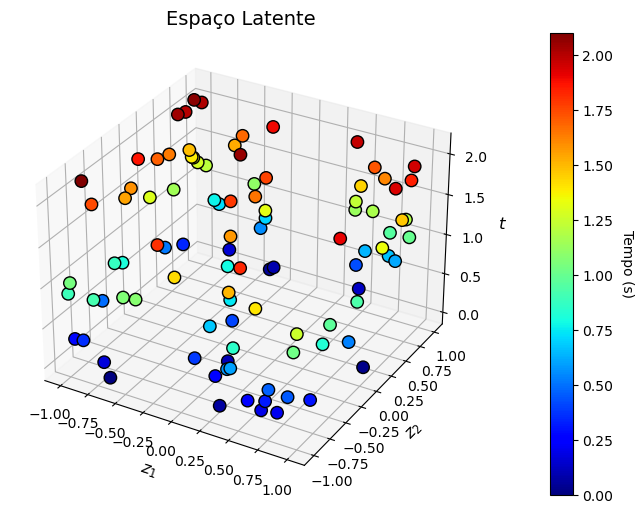

In [ ]:

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')  # Criar um subplot 3D
scatter = ax.scatter(latente[:, 0], latente[:, 1], time, c=time, cmap='jet', s=80, alpha=1.0, edgecolors='k')

# Adicionar colorbar
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Time (s)', rotation=270, labelpad=15)

# Definir título e labels
ax.set_title("Latent Space", fontsize=14)
ax.set_xlabel(r"$z_1$", fontsize=12)
ax.set_ylabel(r"$z_2$", fontsize=12)
ax.set_zlabel(r"$t$", fontsize=12)

# Adicionar grid
ax.grid(True)

# Mostrar o plot
plt.show()


Connect the points to your curve and obtain a shape like this one:


<img src="EspacoLatente.png" alt="Espaço Latente" width="1000">


Now, notice that it can be stretched and deformed to return to our original curve. That is, it's an affine transformation of the curve to \( \theta \).

## Exercises:

Now, try to redo the studies we did above but for a single dimension in \( z \), that is, with `neck=1`. Notice that you'll need to modify some code and also increase the training or the size of the network.